In [1]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
#from u_interpolate_small import regrid_irregular_quick
from datetime import date
import u_interpolate_small as uint
from ndays import numOfDays
import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import pickle

In [2]:
# Define domain and time period
#south africa domain
#start_lat,end_lat,start_lon,end_lon = -28,-7.5,17.5, 30
# west africa domain
start_lat,end_lat,start_lon,end_lon = 8,20,-10,10
#end_lat = -7.5
#start_lon = 17.5 #-18
#end_lon = 30
domain ='WA'
start_year = '2014'
start_month = '07' #'12'
end_year = '2014'
end_month = '09' #'02'
start_day = '01'
end_day = '30'

# find ndays
date1 = date(int(start_year), int(start_month), int(start_day))
date2 = date(int(end_year), int(end_month), int(end_day))
t = numOfDays(date1, date2)+1

# define a regular lat/lon grid close to MSG native resolution (0.04 deg)
reg_lat = np.arange(start_lat, end_lat, 0.04)
reg_lon = np.arange(start_lon, end_lon, 0.04) 

In [3]:
# get native MSG grid (core)
lpath = glob.glob('/prj/Africa_cloud/geoloc/lat_lon_2268_2080.npz')[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system
msg_latlon = np.load(lpath)
mlon = msg_latlon['lon']
mlat = msg_latlon['lat']

In [4]:
# get precip grid and indices using one file
precip_filename = '/prj/global_water/MCS_Feng/global_v2/2d_fields/20100101.0000_20110101.0000/mcstrack_20100901_0630.nc'
precip_data = nc.Dataset(precip_filename,'r')
lat_p_temp = np.array(precip_data.variables['latitude'][:])
lon_p_temp = np.array(precip_data.variables['longitude'][:])
lat_ind_p = np.where((lat_p_temp[:,0]>=start_lat) & (lat_p_temp[:,0]<=end_lat))[0]
lon_ind_p = np.where((lon_p_temp[0,:]>= start_lon) & (lon_p_temp[0,:]<=end_lon))[0]
lat_p = lat_p_temp[lat_ind_p[0]:lat_ind_p[-1]+1,lon_ind_p[0]:lon_ind_p[-1]+1]
lon_p = lon_p_temp[lat_ind_p[0]:lat_ind_p[-1]+1,lon_ind_p[0]:lon_ind_p[-1]+1]

In [5]:
# calculate interpolation weights from MSG (core) and IMERG onto the new regular grid that can be reused to speed up interpolations.
inds, weights, shape = uint.interpolation_weights(mlon, mlat, reg_lon, reg_lat) # save weights for continuous use - MSG interpolation on regular. 

# uncomment line below to include precip interpolation
inds_precip, weights_precip, shape_precip = uint.interpolation_weights(lon_p, lat_p, reg_lon, reg_lat) # save for continuous use - IMERG interpolation weights to same grid. 

In [6]:
# read in precip data 
list_of_file_names_precip=[]

if int(start_year)==int(end_year): 
    dir_name_precip =  '/prj/global_water/MCS_Feng/global_v2/2d_fields/'+start_year+'0101.0000_'+str(int(start_year)+1)+'0101.0000'
    os.chdir(dir_name_precip)
    for m in range(int(start_month),int(end_month)+1,1):
            if m<10:
                month = str(m).zfill(2)
            else:
                month = str(m)   
            all_files=sorted(glob.glob("mcstrack_"+start_year+month+"*.nc"));
            #print(all_files)
            list_of_file_names_precip.append(all_files) # all days in month
             
elif int(start_year)<int(end_year):
    y=1
    for i in range(int(start_year),int(end_year)+1,1):
        dir_name_precip =  '/prj/global_water/MCS_Feng/global_v2/2d_fields/'+str(i)+'0101.0000_'+str(i+1)+'0101.0000/'
        #os.chdir(dir_name_precip)
        if y==1:
            for m in range(int(start_month),12+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)  
                list_of_file_names_precip.append(sorted(glob.glob(dir_name_precip+'mcstrack_'+str(i)+month+'*.nc'))) # day 1
                y=y+1            
        else:
            for m in range(1,int(end_month)+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m) 
                dir_name_precip =  '/prj/global_water/MCS_Feng/global_v2/2d_fields/'+str(i)+'0101.0000_'+str(i+1)+'0101.0000/'
                list_of_file_names_precip.append(sorted(glob.glob(dir_name_precip+'mcstrack_'+str(i)+month+'*.nc'))) # day 1
                    
    
    #print(dir_name_precip)
list_of_files_precip=[]                
for a in range(0,len(list_of_file_names_precip),1):
    list_of_files_precip = list_of_files_precip+list_of_file_names_precip[a]

In [7]:
# preallocate
precip = np.zeros((len(lat_p[:,1]),len(lon_p[1,:]),t*24),dtype=float)
regidded_precip = np.zeros((len(reg_lat),len(reg_lon),t*24),dtype=float)
time_IMERG = np.zeros(t*24)    
    
for l in range(0,len(list_of_files_precip),1):#22,31,1):#
    precip_filename = list_of_files_precip[l]
    print(precip_filename)
    print(l)
    precip_data = nc.Dataset(precip_filename,'r')
   # precip_temp = np.array(precip_data.variables['precipitation'])[0,:,:]
    precip_temp = np.array(precip_data.variables['precipitation'])[0,lat_ind_p[0]:lat_ind_p[-1]+1,lon_ind_p[0]:lon_ind_p[-1]+1]
    precip[:,:,l] = precip_temp  
    time_IMERG[l]= str(precip_filename[-16:-3])
    regidded_precip[:,:,l] = uint.interpolate_data(precip_temp, inds_precip, weights_precip, shape_precip)  # interpolation using saved weights for MSG TIR


mcstrack_20140701_0030.nc
0
mcstrack_20140701_0130.nc
1
mcstrack_20140701_0230.nc
2
mcstrack_20140701_0330.nc
3
mcstrack_20140701_0430.nc
4
mcstrack_20140701_0530.nc
5
mcstrack_20140701_0630.nc
6
mcstrack_20140701_0730.nc
7
mcstrack_20140701_0830.nc
8
mcstrack_20140701_0930.nc
9
mcstrack_20140701_1030.nc
10
mcstrack_20140701_1130.nc
11
mcstrack_20140701_1230.nc
12
mcstrack_20140701_1330.nc
13
mcstrack_20140701_1430.nc
14
mcstrack_20140701_1530.nc
15
mcstrack_20140701_1630.nc
16
mcstrack_20140701_1730.nc
17
mcstrack_20140701_1830.nc
18
mcstrack_20140701_1930.nc
19
mcstrack_20140701_2030.nc
20
mcstrack_20140701_2130.nc
21
mcstrack_20140701_2230.nc
22
mcstrack_20140701_2330.nc
23
mcstrack_20140702_0030.nc
24
mcstrack_20140702_0130.nc
25
mcstrack_20140702_0230.nc
26
mcstrack_20140702_0330.nc
27
mcstrack_20140702_0430.nc
28
mcstrack_20140702_0530.nc
29
mcstrack_20140702_0630.nc
30
mcstrack_20140702_0730.nc
31
mcstrack_20140702_0830.nc
32
mcstrack_20140702_0930.nc
33
mcstrack_20140702_1030.n

mcstrack_20140712_1330.nc
277
mcstrack_20140712_1430.nc
278
mcstrack_20140712_1530.nc
279
mcstrack_20140712_1630.nc
280
mcstrack_20140712_1730.nc
281
mcstrack_20140712_1830.nc
282
mcstrack_20140712_1930.nc
283
mcstrack_20140712_2030.nc
284
mcstrack_20140712_2130.nc
285
mcstrack_20140712_2230.nc
286
mcstrack_20140712_2330.nc
287
mcstrack_20140713_0030.nc
288
mcstrack_20140713_0130.nc
289
mcstrack_20140713_0230.nc
290
mcstrack_20140713_0330.nc
291
mcstrack_20140713_0430.nc
292
mcstrack_20140713_0530.nc
293
mcstrack_20140713_0630.nc
294
mcstrack_20140713_0730.nc
295
mcstrack_20140713_0830.nc
296
mcstrack_20140713_0930.nc
297
mcstrack_20140713_1030.nc
298
mcstrack_20140713_1130.nc
299
mcstrack_20140713_1230.nc
300
mcstrack_20140713_1330.nc
301
mcstrack_20140713_1430.nc
302
mcstrack_20140713_1530.nc
303
mcstrack_20140713_1630.nc
304
mcstrack_20140713_1730.nc
305
mcstrack_20140713_1830.nc
306
mcstrack_20140713_1930.nc
307
mcstrack_20140713_2030.nc
308
mcstrack_20140713_2130.nc
309
mcstrack_2

mcstrack_20140723_2330.nc
551
mcstrack_20140724_0030.nc
552
mcstrack_20140724_0130.nc
553
mcstrack_20140724_0230.nc
554
mcstrack_20140724_0330.nc
555
mcstrack_20140724_0430.nc
556
mcstrack_20140724_0530.nc
557
mcstrack_20140724_0630.nc
558
mcstrack_20140724_0730.nc
559
mcstrack_20140724_0830.nc
560
mcstrack_20140724_0930.nc
561
mcstrack_20140724_1030.nc
562
mcstrack_20140724_1130.nc
563
mcstrack_20140724_1230.nc
564
mcstrack_20140724_1330.nc
565
mcstrack_20140724_1430.nc
566
mcstrack_20140724_1530.nc
567
mcstrack_20140724_1630.nc
568
mcstrack_20140724_1730.nc
569
mcstrack_20140724_1830.nc
570
mcstrack_20140724_1930.nc
571
mcstrack_20140724_2030.nc
572
mcstrack_20140724_2130.nc
573
mcstrack_20140724_2230.nc
574
mcstrack_20140724_2330.nc
575
mcstrack_20140725_0030.nc
576
mcstrack_20140725_0130.nc
577
mcstrack_20140725_0230.nc
578
mcstrack_20140725_0330.nc
579
mcstrack_20140725_0430.nc
580
mcstrack_20140725_0530.nc
581
mcstrack_20140725_0630.nc
582
mcstrack_20140725_0730.nc
583
mcstrack_2

mcstrack_20140804_1130.nc
825
mcstrack_20140804_1230.nc
826
mcstrack_20140804_1330.nc
827
mcstrack_20140804_1430.nc
828
mcstrack_20140804_1530.nc
829
mcstrack_20140804_1630.nc
830
mcstrack_20140804_1730.nc
831
mcstrack_20140804_1830.nc
832
mcstrack_20140804_1930.nc
833
mcstrack_20140804_2030.nc
834
mcstrack_20140804_2130.nc
835
mcstrack_20140804_2230.nc
836
mcstrack_20140804_2330.nc
837
mcstrack_20140805_0030.nc
838
mcstrack_20140805_0130.nc
839
mcstrack_20140805_0230.nc
840
mcstrack_20140805_0330.nc
841
mcstrack_20140805_0430.nc
842
mcstrack_20140805_0530.nc
843
mcstrack_20140805_0630.nc
844
mcstrack_20140805_0730.nc
845
mcstrack_20140805_0830.nc
846
mcstrack_20140805_0930.nc
847
mcstrack_20140805_1030.nc
848
mcstrack_20140805_1130.nc
849
mcstrack_20140805_1230.nc
850
mcstrack_20140805_1330.nc
851
mcstrack_20140805_1430.nc
852
mcstrack_20140805_1530.nc
853
mcstrack_20140805_1630.nc
854
mcstrack_20140805_1730.nc
855
mcstrack_20140805_1830.nc
856
mcstrack_20140805_1930.nc
857
mcstrack_2

mcstrack_20140815_1730.nc
1095
mcstrack_20140815_1830.nc
1096
mcstrack_20140815_1930.nc
1097
mcstrack_20140815_2030.nc
1098
mcstrack_20140815_2130.nc
1099
mcstrack_20140815_2230.nc
1100
mcstrack_20140815_2330.nc
1101
mcstrack_20140816_0030.nc
1102
mcstrack_20140816_0130.nc
1103
mcstrack_20140816_0230.nc
1104
mcstrack_20140816_0330.nc
1105
mcstrack_20140816_0430.nc
1106
mcstrack_20140816_0530.nc
1107
mcstrack_20140816_0630.nc
1108
mcstrack_20140816_0730.nc
1109
mcstrack_20140816_0830.nc
1110
mcstrack_20140816_0930.nc
1111
mcstrack_20140816_1030.nc
1112
mcstrack_20140816_1130.nc
1113
mcstrack_20140816_1230.nc
1114
mcstrack_20140816_1330.nc
1115
mcstrack_20140816_1430.nc
1116
mcstrack_20140816_1530.nc
1117
mcstrack_20140816_1630.nc
1118
mcstrack_20140816_1730.nc
1119
mcstrack_20140816_1830.nc
1120
mcstrack_20140816_1930.nc
1121
mcstrack_20140816_2030.nc
1122
mcstrack_20140816_2130.nc
1123
mcstrack_20140816_2230.nc
1124
mcstrack_20140816_2330.nc
1125
mcstrack_20140817_0030.nc
1126
mcstrack

mcstrack_20140826_1830.nc
1360
mcstrack_20140826_1930.nc
1361
mcstrack_20140826_2030.nc
1362
mcstrack_20140826_2130.nc
1363
mcstrack_20140826_2230.nc
1364
mcstrack_20140826_2330.nc
1365
mcstrack_20140827_0030.nc
1366
mcstrack_20140827_0130.nc
1367
mcstrack_20140827_0230.nc
1368
mcstrack_20140827_0330.nc
1369
mcstrack_20140827_0430.nc
1370
mcstrack_20140827_0530.nc
1371
mcstrack_20140827_0630.nc
1372
mcstrack_20140827_0730.nc
1373
mcstrack_20140827_0830.nc
1374
mcstrack_20140827_0930.nc
1375
mcstrack_20140827_1030.nc
1376
mcstrack_20140827_1130.nc
1377
mcstrack_20140827_1230.nc
1378
mcstrack_20140827_1330.nc
1379
mcstrack_20140827_1430.nc
1380
mcstrack_20140827_1530.nc
1381
mcstrack_20140827_1630.nc
1382
mcstrack_20140827_1730.nc
1383
mcstrack_20140827_1830.nc
1384
mcstrack_20140827_1930.nc
1385
mcstrack_20140827_2030.nc
1386
mcstrack_20140827_2130.nc
1387
mcstrack_20140827_2230.nc
1388
mcstrack_20140827_2330.nc
1389
mcstrack_20140828_0030.nc
1390
mcstrack_20140828_0130.nc
1391
mcstrack

mcstrack_20140906_1930.nc
1625
mcstrack_20140906_2030.nc
1626
mcstrack_20140906_2130.nc
1627
mcstrack_20140906_2230.nc
1628
mcstrack_20140906_2330.nc
1629
mcstrack_20140907_0030.nc
1630
mcstrack_20140907_0130.nc
1631
mcstrack_20140907_0230.nc
1632
mcstrack_20140907_0330.nc
1633
mcstrack_20140907_0430.nc
1634
mcstrack_20140907_0530.nc
1635
mcstrack_20140907_0630.nc
1636
mcstrack_20140907_0730.nc
1637
mcstrack_20140907_0830.nc
1638
mcstrack_20140907_0930.nc
1639
mcstrack_20140907_1030.nc
1640
mcstrack_20140907_1130.nc
1641
mcstrack_20140907_1230.nc
1642
mcstrack_20140907_1330.nc
1643
mcstrack_20140907_1430.nc
1644
mcstrack_20140907_1530.nc
1645
mcstrack_20140907_1630.nc
1646
mcstrack_20140907_1730.nc
1647
mcstrack_20140907_1830.nc
1648
mcstrack_20140907_1930.nc
1649
mcstrack_20140907_2030.nc
1650
mcstrack_20140907_2130.nc
1651
mcstrack_20140907_2230.nc
1652
mcstrack_20140907_2330.nc
1653
mcstrack_20140908_0030.nc
1654
mcstrack_20140908_0130.nc
1655
mcstrack_20140908_0230.nc
1656
mcstrack

mcstrack_20140917_2030.nc
1890
mcstrack_20140917_2130.nc
1891
mcstrack_20140917_2230.nc
1892
mcstrack_20140917_2330.nc
1893
mcstrack_20140918_0030.nc
1894
mcstrack_20140918_0130.nc
1895
mcstrack_20140918_0230.nc
1896
mcstrack_20140918_0330.nc
1897
mcstrack_20140918_0430.nc
1898
mcstrack_20140918_0530.nc
1899
mcstrack_20140918_0630.nc
1900
mcstrack_20140918_0730.nc
1901
mcstrack_20140918_0830.nc
1902
mcstrack_20140918_0930.nc
1903
mcstrack_20140918_1030.nc
1904
mcstrack_20140918_1130.nc
1905
mcstrack_20140918_1230.nc
1906
mcstrack_20140918_1330.nc
1907
mcstrack_20140918_1430.nc
1908
mcstrack_20140918_1530.nc
1909
mcstrack_20140918_1630.nc
1910
mcstrack_20140918_1730.nc
1911
mcstrack_20140918_1830.nc
1912
mcstrack_20140918_1930.nc
1913
mcstrack_20140918_2030.nc
1914
mcstrack_20140918_2130.nc
1915
mcstrack_20140918_2230.nc
1916
mcstrack_20140918_2330.nc
1917
mcstrack_20140919_0030.nc
1918
mcstrack_20140919_0130.nc
1919
mcstrack_20140919_0230.nc
1920
mcstrack_20140919_0330.nc
1921
mcstrack

mcstrack_20140928_2130.nc
2155
mcstrack_20140928_2230.nc
2156
mcstrack_20140928_2330.nc
2157
mcstrack_20140929_0030.nc
2158
mcstrack_20140929_0130.nc
2159
mcstrack_20140929_0230.nc
2160
mcstrack_20140929_0330.nc
2161
mcstrack_20140929_0430.nc
2162
mcstrack_20140929_0530.nc
2163
mcstrack_20140929_0630.nc
2164
mcstrack_20140929_0730.nc
2165
mcstrack_20140929_0830.nc
2166
mcstrack_20140929_0930.nc
2167
mcstrack_20140929_1030.nc
2168
mcstrack_20140929_1130.nc
2169
mcstrack_20140929_1230.nc
2170
mcstrack_20140929_1330.nc
2171
mcstrack_20140929_1430.nc
2172
mcstrack_20140929_1530.nc
2173
mcstrack_20140929_1630.nc
2174
mcstrack_20140929_1730.nc
2175
mcstrack_20140929_1830.nc
2176
mcstrack_20140929_1930.nc
2177
mcstrack_20140929_2030.nc
2178
mcstrack_20140929_2130.nc
2179
mcstrack_20140929_2230.nc
2180
mcstrack_20140929_2330.nc
2181
mcstrack_20140930_0030.nc
2182
mcstrack_20140930_0130.nc
2183
mcstrack_20140930_0230.nc
2184
mcstrack_20140930_0330.nc
2185
mcstrack_20140930_0430.nc
2186
mcstrack

In [8]:
# read in cores data
cores = np.zeros((len(reg_lat),len(reg_lon),t*24),dtype=float) #using every fourth value for hourly comparison- 24hr
tir = np.zeros((len(reg_lat),len(reg_lon),t*24),dtype=float) #using every fourth value for hourly comparison- 24hr
time_core = np.zeros((t*24)) #using every fourth value for hourly comparison- 24hr

list_of_file_names = []

for i in range(0,len(time_IMERG),1):
    current_file = str(time_IMERG[i])#+'.nc'
    SY= current_file[0:4]
    MM= current_file[4:6]
    all_file_names = '/prj/Africa_cloud/ch9_wavelet/'+SY+'/'+MM+'/'+current_file[0:-2]+'.nc' 
    if os.path.isfile(all_file_names):      
        list_of_file_names.append(all_file_names) # all days in month
    else:
        list_of_file_names.append('file_not_available') # all days in month
            
 
 #print(list_of_file_names)

In [9]:
cores_temp= np.zeros((len(reg_lat),len(reg_lon)))*np.nan
for l in range(0,len(list_of_file_names),1):#2, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_file_names[l]#'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    if os.path.isfile(core_filename):      
        ds = xr.open_dataset(core_filename).squeeze() # pick any convective core file from ch9_wavelet. 
        print(l)
        cores[:,:,l] = uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
        tir[:,:,l] = uint.interpolate_data(ds['tir'].values, inds, weights, shape)  # interpolation using saved weights for MSG TIR      
        time_core[l] = str(core_filename[-15:-3])
    else:
        cores[:,:,l] = cores_temp
        tir[:,:,l] = cores_temp  
        time_core[l] = np.nan#str(core_filename[-15:-3])
  

/prj/Africa_cloud/ch9_wavelet/2014/07/201407010030.nc
0
/prj/Africa_cloud/ch9_wavelet/2014/07/201407010130.nc
1
/prj/Africa_cloud/ch9_wavelet/2014/07/201407010230.nc
2
/prj/Africa_cloud/ch9_wavelet/2014/07/201407010330.nc
3
/prj/Africa_cloud/ch9_wavelet/2014/07/201407010430.nc
4
/prj/Africa_cloud/ch9_wavelet/2014/07/201407010530.nc
5
/prj/Africa_cloud/ch9_wavelet/2014/07/201407010630.nc
6
/prj/Africa_cloud/ch9_wavelet/2014/07/201407010730.nc
7
/prj/Africa_cloud/ch9_wavelet/2014/07/201407010830.nc
8
/prj/Africa_cloud/ch9_wavelet/2014/07/201407010930.nc
9
/prj/Africa_cloud/ch9_wavelet/2014/07/201407011030.nc
10
/prj/Africa_cloud/ch9_wavelet/2014/07/201407011130.nc
11
/prj/Africa_cloud/ch9_wavelet/2014/07/201407011230.nc
12
/prj/Africa_cloud/ch9_wavelet/2014/07/201407011330.nc
13
/prj/Africa_cloud/ch9_wavelet/2014/07/201407011430.nc
14
/prj/Africa_cloud/ch9_wavelet/2014/07/201407011530.nc
15
/prj/Africa_cloud/ch9_wavelet/2014/07/201407011630.nc
16
/prj/Africa_cloud/ch9_wavelet/2014/07/201

143
/prj/Africa_cloud/ch9_wavelet/2014/07/201407070030.nc
144
/prj/Africa_cloud/ch9_wavelet/2014/07/201407070130.nc
145
/prj/Africa_cloud/ch9_wavelet/2014/07/201407070230.nc
146
/prj/Africa_cloud/ch9_wavelet/2014/07/201407070330.nc
147
/prj/Africa_cloud/ch9_wavelet/2014/07/201407070430.nc
148
/prj/Africa_cloud/ch9_wavelet/2014/07/201407070530.nc
149
/prj/Africa_cloud/ch9_wavelet/2014/07/201407070630.nc
150
/prj/Africa_cloud/ch9_wavelet/2014/07/201407070730.nc
151
/prj/Africa_cloud/ch9_wavelet/2014/07/201407070830.nc
152
/prj/Africa_cloud/ch9_wavelet/2014/07/201407070930.nc
153
/prj/Africa_cloud/ch9_wavelet/2014/07/201407071030.nc
154
/prj/Africa_cloud/ch9_wavelet/2014/07/201407071130.nc
155
/prj/Africa_cloud/ch9_wavelet/2014/07/201407071230.nc
156
/prj/Africa_cloud/ch9_wavelet/2014/07/201407071330.nc
157
/prj/Africa_cloud/ch9_wavelet/2014/07/201407071430.nc
158
/prj/Africa_cloud/ch9_wavelet/2014/07/201407071530.nc
159
/prj/Africa_cloud/ch9_wavelet/2014/07/201407071630.nc
160
/prj/Afric

/prj/Africa_cloud/ch9_wavelet/2014/07/201407122230.nc
286
/prj/Africa_cloud/ch9_wavelet/2014/07/201407122330.nc
287
/prj/Africa_cloud/ch9_wavelet/2014/07/201407130030.nc
288
/prj/Africa_cloud/ch9_wavelet/2014/07/201407130130.nc
289
/prj/Africa_cloud/ch9_wavelet/2014/07/201407130230.nc
290
/prj/Africa_cloud/ch9_wavelet/2014/07/201407130330.nc
291
/prj/Africa_cloud/ch9_wavelet/2014/07/201407130430.nc
292
/prj/Africa_cloud/ch9_wavelet/2014/07/201407130530.nc
293
/prj/Africa_cloud/ch9_wavelet/2014/07/201407130630.nc
294
/prj/Africa_cloud/ch9_wavelet/2014/07/201407130730.nc
295
/prj/Africa_cloud/ch9_wavelet/2014/07/201407130830.nc
296
/prj/Africa_cloud/ch9_wavelet/2014/07/201407130930.nc
297
/prj/Africa_cloud/ch9_wavelet/2014/07/201407131030.nc
298
/prj/Africa_cloud/ch9_wavelet/2014/07/201407131130.nc
299
/prj/Africa_cloud/ch9_wavelet/2014/07/201407131230.nc
300
/prj/Africa_cloud/ch9_wavelet/2014/07/201407131330.nc
301
/prj/Africa_cloud/ch9_wavelet/2014/07/201407131430.nc
302
/prj/Africa_cl

428
/prj/Africa_cloud/ch9_wavelet/2014/07/201407182130.nc
429
/prj/Africa_cloud/ch9_wavelet/2014/07/201407182230.nc
430
/prj/Africa_cloud/ch9_wavelet/2014/07/201407182330.nc
431
/prj/Africa_cloud/ch9_wavelet/2014/07/201407190030.nc
432
/prj/Africa_cloud/ch9_wavelet/2014/07/201407190130.nc
433
/prj/Africa_cloud/ch9_wavelet/2014/07/201407190230.nc
434
/prj/Africa_cloud/ch9_wavelet/2014/07/201407190330.nc
435
/prj/Africa_cloud/ch9_wavelet/2014/07/201407190430.nc
436
/prj/Africa_cloud/ch9_wavelet/2014/07/201407190530.nc
437
/prj/Africa_cloud/ch9_wavelet/2014/07/201407190630.nc
438
/prj/Africa_cloud/ch9_wavelet/2014/07/201407190730.nc
439
/prj/Africa_cloud/ch9_wavelet/2014/07/201407190830.nc
440
/prj/Africa_cloud/ch9_wavelet/2014/07/201407190930.nc
441
/prj/Africa_cloud/ch9_wavelet/2014/07/201407191030.nc
442
/prj/Africa_cloud/ch9_wavelet/2014/07/201407191130.nc
443
/prj/Africa_cloud/ch9_wavelet/2014/07/201407191230.nc
444
/prj/Africa_cloud/ch9_wavelet/2014/07/201407191330.nc
445
/prj/Afric

570
/prj/Africa_cloud/ch9_wavelet/2014/07/201407241930.nc
571
/prj/Africa_cloud/ch9_wavelet/2014/07/201407242030.nc
572
/prj/Africa_cloud/ch9_wavelet/2014/07/201407242130.nc
573
/prj/Africa_cloud/ch9_wavelet/2014/07/201407242230.nc
574
/prj/Africa_cloud/ch9_wavelet/2014/07/201407242330.nc
575
/prj/Africa_cloud/ch9_wavelet/2014/07/201407250030.nc
576
/prj/Africa_cloud/ch9_wavelet/2014/07/201407250130.nc
577
/prj/Africa_cloud/ch9_wavelet/2014/07/201407250230.nc
578
/prj/Africa_cloud/ch9_wavelet/2014/07/201407250330.nc
579
/prj/Africa_cloud/ch9_wavelet/2014/07/201407250430.nc
580
/prj/Africa_cloud/ch9_wavelet/2014/07/201407250530.nc
581
/prj/Africa_cloud/ch9_wavelet/2014/07/201407250630.nc
582
/prj/Africa_cloud/ch9_wavelet/2014/07/201407250730.nc
583
/prj/Africa_cloud/ch9_wavelet/2014/07/201407250830.nc
584
/prj/Africa_cloud/ch9_wavelet/2014/07/201407250930.nc
585
/prj/Africa_cloud/ch9_wavelet/2014/07/201407251030.nc
586
/prj/Africa_cloud/ch9_wavelet/2014/07/201407251130.nc
587
/prj/Afric

/prj/Africa_cloud/ch9_wavelet/2014/07/201407301930.nc
713
/prj/Africa_cloud/ch9_wavelet/2014/07/201407302030.nc
714
/prj/Africa_cloud/ch9_wavelet/2014/07/201407302130.nc
715
/prj/Africa_cloud/ch9_wavelet/2014/07/201407302230.nc
716
/prj/Africa_cloud/ch9_wavelet/2014/07/201407302330.nc
717
/prj/Africa_cloud/ch9_wavelet/2014/07/201407310030.nc
718
/prj/Africa_cloud/ch9_wavelet/2014/07/201407310130.nc
719
/prj/Africa_cloud/ch9_wavelet/2014/07/201407310230.nc
720
/prj/Africa_cloud/ch9_wavelet/2014/07/201407310330.nc
721
/prj/Africa_cloud/ch9_wavelet/2014/07/201407310430.nc
722
/prj/Africa_cloud/ch9_wavelet/2014/07/201407310530.nc
723
/prj/Africa_cloud/ch9_wavelet/2014/07/201407310630.nc
724
/prj/Africa_cloud/ch9_wavelet/2014/07/201407310730.nc
725
/prj/Africa_cloud/ch9_wavelet/2014/07/201407310830.nc
726
/prj/Africa_cloud/ch9_wavelet/2014/07/201407310930.nc
727
/prj/Africa_cloud/ch9_wavelet/2014/07/201407311030.nc
728
/prj/Africa_cloud/ch9_wavelet/2014/07/201407311130.nc
729
/prj/Africa_cl

/prj/Africa_cloud/ch9_wavelet/2014/08/201408080930.nc
919
/prj/Africa_cloud/ch9_wavelet/2014/08/201408081030.nc
920
/prj/Africa_cloud/ch9_wavelet/2014/08/201408081130.nc
921
/prj/Africa_cloud/ch9_wavelet/2014/08/201408081230.nc
922
/prj/Africa_cloud/ch9_wavelet/2014/08/201408081330.nc
923
/prj/Africa_cloud/ch9_wavelet/2014/08/201408081430.nc
924
/prj/Africa_cloud/ch9_wavelet/2014/08/201408081530.nc
925
/prj/Africa_cloud/ch9_wavelet/2014/08/201408081630.nc
926
/prj/Africa_cloud/ch9_wavelet/2014/08/201408081730.nc
927
/prj/Africa_cloud/ch9_wavelet/2014/08/201408081830.nc
928
/prj/Africa_cloud/ch9_wavelet/2014/08/201408081930.nc
929
/prj/Africa_cloud/ch9_wavelet/2014/08/201408082030.nc
930
/prj/Africa_cloud/ch9_wavelet/2014/08/201408082130.nc
931
/prj/Africa_cloud/ch9_wavelet/2014/08/201408082230.nc
932
/prj/Africa_cloud/ch9_wavelet/2014/08/201408082330.nc
933
/prj/Africa_cloud/ch9_wavelet/2014/08/201408090030.nc
934
/prj/Africa_cloud/ch9_wavelet/2014/08/201408090130.nc
935
/prj/Africa_cl

1059
/prj/Africa_cloud/ch9_wavelet/2014/08/201408140630.nc
1060
/prj/Africa_cloud/ch9_wavelet/2014/08/201408140730.nc
1061
/prj/Africa_cloud/ch9_wavelet/2014/08/201408140830.nc
1062
/prj/Africa_cloud/ch9_wavelet/2014/08/201408140930.nc
1063
/prj/Africa_cloud/ch9_wavelet/2014/08/201408141030.nc
1064
/prj/Africa_cloud/ch9_wavelet/2014/08/201408141130.nc
1065
/prj/Africa_cloud/ch9_wavelet/2014/08/201408141230.nc
1066
/prj/Africa_cloud/ch9_wavelet/2014/08/201408141330.nc
1067
/prj/Africa_cloud/ch9_wavelet/2014/08/201408141430.nc
1068
/prj/Africa_cloud/ch9_wavelet/2014/08/201408141530.nc
1069
/prj/Africa_cloud/ch9_wavelet/2014/08/201408141630.nc
1070
/prj/Africa_cloud/ch9_wavelet/2014/08/201408141730.nc
1071
/prj/Africa_cloud/ch9_wavelet/2014/08/201408141830.nc
1072
/prj/Africa_cloud/ch9_wavelet/2014/08/201408141930.nc
1073
/prj/Africa_cloud/ch9_wavelet/2014/08/201408142030.nc
1074
/prj/Africa_cloud/ch9_wavelet/2014/08/201408142130.nc
1075
/prj/Africa_cloud/ch9_wavelet/2014/08/201408142230.

/prj/Africa_cloud/ch9_wavelet/2014/08/201408200130.nc
1199
/prj/Africa_cloud/ch9_wavelet/2014/08/201408200230.nc
1200
/prj/Africa_cloud/ch9_wavelet/2014/08/201408200330.nc
1201
/prj/Africa_cloud/ch9_wavelet/2014/08/201408200430.nc
1202
/prj/Africa_cloud/ch9_wavelet/2014/08/201408200530.nc
1203
/prj/Africa_cloud/ch9_wavelet/2014/08/201408200630.nc
1204
/prj/Africa_cloud/ch9_wavelet/2014/08/201408200730.nc
1205
/prj/Africa_cloud/ch9_wavelet/2014/08/201408200830.nc
1206
/prj/Africa_cloud/ch9_wavelet/2014/08/201408200930.nc
1207
/prj/Africa_cloud/ch9_wavelet/2014/08/201408201030.nc
1208
/prj/Africa_cloud/ch9_wavelet/2014/08/201408201130.nc
1209
/prj/Africa_cloud/ch9_wavelet/2014/08/201408201230.nc
1210
/prj/Africa_cloud/ch9_wavelet/2014/08/201408201330.nc
1211
/prj/Africa_cloud/ch9_wavelet/2014/08/201408201430.nc
1212
/prj/Africa_cloud/ch9_wavelet/2014/08/201408201530.nc
1213
/prj/Africa_cloud/ch9_wavelet/2014/08/201408201630.nc
1214
/prj/Africa_cloud/ch9_wavelet/2014/08/201408201730.nc
12

1337
/prj/Africa_cloud/ch9_wavelet/2014/08/201408252030.nc
1338
/prj/Africa_cloud/ch9_wavelet/2014/08/201408252130.nc
1339
/prj/Africa_cloud/ch9_wavelet/2014/08/201408252230.nc
1340
/prj/Africa_cloud/ch9_wavelet/2014/08/201408252330.nc
1341
/prj/Africa_cloud/ch9_wavelet/2014/08/201408260030.nc
1342
/prj/Africa_cloud/ch9_wavelet/2014/08/201408260130.nc
1343
/prj/Africa_cloud/ch9_wavelet/2014/08/201408260230.nc
1344
/prj/Africa_cloud/ch9_wavelet/2014/08/201408260330.nc
1345
/prj/Africa_cloud/ch9_wavelet/2014/08/201408260430.nc
1346
/prj/Africa_cloud/ch9_wavelet/2014/08/201408260530.nc
1347
/prj/Africa_cloud/ch9_wavelet/2014/08/201408260630.nc
1348
/prj/Africa_cloud/ch9_wavelet/2014/08/201408260730.nc
1349
/prj/Africa_cloud/ch9_wavelet/2014/08/201408260830.nc
1350
/prj/Africa_cloud/ch9_wavelet/2014/08/201408260930.nc
1351
/prj/Africa_cloud/ch9_wavelet/2014/08/201408261030.nc
1352
/prj/Africa_cloud/ch9_wavelet/2014/08/201408261130.nc
1353
/prj/Africa_cloud/ch9_wavelet/2014/08/201408261230.

1476
/prj/Africa_cloud/ch9_wavelet/2014/08/201408311530.nc
1477
/prj/Africa_cloud/ch9_wavelet/2014/08/201408311630.nc
1478
/prj/Africa_cloud/ch9_wavelet/2014/08/201408311730.nc
1479
/prj/Africa_cloud/ch9_wavelet/2014/08/201408311830.nc
1480
/prj/Africa_cloud/ch9_wavelet/2014/08/201408311930.nc
1481
/prj/Africa_cloud/ch9_wavelet/2014/08/201408312030.nc
1482
/prj/Africa_cloud/ch9_wavelet/2014/08/201408312130.nc
1483
/prj/Africa_cloud/ch9_wavelet/2014/08/201408312230.nc
1484
/prj/Africa_cloud/ch9_wavelet/2014/08/201408312330.nc
1485
/prj/Africa_cloud/ch9_wavelet/2014/09/201409010030.nc
1486
/prj/Africa_cloud/ch9_wavelet/2014/09/201409010130.nc
1487
/prj/Africa_cloud/ch9_wavelet/2014/09/201409010230.nc
1488
/prj/Africa_cloud/ch9_wavelet/2014/09/201409010330.nc
1489
/prj/Africa_cloud/ch9_wavelet/2014/09/201409010430.nc
1490
/prj/Africa_cloud/ch9_wavelet/2014/09/201409010530.nc
1491
/prj/Africa_cloud/ch9_wavelet/2014/09/201409010630.nc
1492
/prj/Africa_cloud/ch9_wavelet/2014/09/201409010730.

1616
/prj/Africa_cloud/ch9_wavelet/2014/09/201409061130.nc
1617
/prj/Africa_cloud/ch9_wavelet/2014/09/201409061230.nc
1618
/prj/Africa_cloud/ch9_wavelet/2014/09/201409061330.nc
1619
/prj/Africa_cloud/ch9_wavelet/2014/09/201409061430.nc
1620
/prj/Africa_cloud/ch9_wavelet/2014/09/201409061530.nc
1621
/prj/Africa_cloud/ch9_wavelet/2014/09/201409061630.nc
1622
/prj/Africa_cloud/ch9_wavelet/2014/09/201409061730.nc
1623
/prj/Africa_cloud/ch9_wavelet/2014/09/201409061830.nc
1624
/prj/Africa_cloud/ch9_wavelet/2014/09/201409061930.nc
1625
/prj/Africa_cloud/ch9_wavelet/2014/09/201409062030.nc
1626
/prj/Africa_cloud/ch9_wavelet/2014/09/201409062130.nc
1627
/prj/Africa_cloud/ch9_wavelet/2014/09/201409062230.nc
1628
/prj/Africa_cloud/ch9_wavelet/2014/09/201409062330.nc
1629
/prj/Africa_cloud/ch9_wavelet/2014/09/201409070030.nc
1630
/prj/Africa_cloud/ch9_wavelet/2014/09/201409070130.nc
1631
/prj/Africa_cloud/ch9_wavelet/2014/09/201409070230.nc
1632
/prj/Africa_cloud/ch9_wavelet/2014/09/201409070330.

/prj/Africa_cloud/ch9_wavelet/2014/09/201409120630.nc
1756
/prj/Africa_cloud/ch9_wavelet/2014/09/201409120730.nc
1757
/prj/Africa_cloud/ch9_wavelet/2014/09/201409120830.nc
1758
/prj/Africa_cloud/ch9_wavelet/2014/09/201409120930.nc
1759
/prj/Africa_cloud/ch9_wavelet/2014/09/201409121030.nc
1760
/prj/Africa_cloud/ch9_wavelet/2014/09/201409121130.nc
1761
/prj/Africa_cloud/ch9_wavelet/2014/09/201409121230.nc
1762
/prj/Africa_cloud/ch9_wavelet/2014/09/201409121330.nc
1763
/prj/Africa_cloud/ch9_wavelet/2014/09/201409121430.nc
1764
/prj/Africa_cloud/ch9_wavelet/2014/09/201409121530.nc
1765
/prj/Africa_cloud/ch9_wavelet/2014/09/201409121630.nc
1766
/prj/Africa_cloud/ch9_wavelet/2014/09/201409121730.nc
1767
/prj/Africa_cloud/ch9_wavelet/2014/09/201409121830.nc
1768
/prj/Africa_cloud/ch9_wavelet/2014/09/201409121930.nc
1769
/prj/Africa_cloud/ch9_wavelet/2014/09/201409122030.nc
1770
/prj/Africa_cloud/ch9_wavelet/2014/09/201409122130.nc
1771
/prj/Africa_cloud/ch9_wavelet/2014/09/201409122230.nc
17

/prj/Africa_cloud/ch9_wavelet/2014/09/201409180130.nc
1895
/prj/Africa_cloud/ch9_wavelet/2014/09/201409180230.nc
1896
/prj/Africa_cloud/ch9_wavelet/2014/09/201409180330.nc
1897
/prj/Africa_cloud/ch9_wavelet/2014/09/201409180430.nc
1898
/prj/Africa_cloud/ch9_wavelet/2014/09/201409180530.nc
1899
/prj/Africa_cloud/ch9_wavelet/2014/09/201409180630.nc
1900
/prj/Africa_cloud/ch9_wavelet/2014/09/201409180730.nc
1901
/prj/Africa_cloud/ch9_wavelet/2014/09/201409180830.nc
1902
/prj/Africa_cloud/ch9_wavelet/2014/09/201409180930.nc
1903
/prj/Africa_cloud/ch9_wavelet/2014/09/201409181030.nc
1904
/prj/Africa_cloud/ch9_wavelet/2014/09/201409181130.nc
1905
/prj/Africa_cloud/ch9_wavelet/2014/09/201409181230.nc
1906
/prj/Africa_cloud/ch9_wavelet/2014/09/201409181330.nc
1907
/prj/Africa_cloud/ch9_wavelet/2014/09/201409181430.nc
1908
/prj/Africa_cloud/ch9_wavelet/2014/09/201409181530.nc
1909
/prj/Africa_cloud/ch9_wavelet/2014/09/201409181630.nc
1910
/prj/Africa_cloud/ch9_wavelet/2014/09/201409181730.nc
19

2034
/prj/Africa_cloud/ch9_wavelet/2014/09/201409232130.nc
2035
/prj/Africa_cloud/ch9_wavelet/2014/09/201409232230.nc
2036
/prj/Africa_cloud/ch9_wavelet/2014/09/201409232330.nc
2037
/prj/Africa_cloud/ch9_wavelet/2014/09/201409240030.nc
2038
/prj/Africa_cloud/ch9_wavelet/2014/09/201409240130.nc
2039
/prj/Africa_cloud/ch9_wavelet/2014/09/201409240230.nc
2040
/prj/Africa_cloud/ch9_wavelet/2014/09/201409240330.nc
2041
/prj/Africa_cloud/ch9_wavelet/2014/09/201409240430.nc
2042
/prj/Africa_cloud/ch9_wavelet/2014/09/201409240530.nc
2043
/prj/Africa_cloud/ch9_wavelet/2014/09/201409240630.nc
2044
/prj/Africa_cloud/ch9_wavelet/2014/09/201409240730.nc
2045
/prj/Africa_cloud/ch9_wavelet/2014/09/201409240830.nc
2046
/prj/Africa_cloud/ch9_wavelet/2014/09/201409240930.nc
2047
/prj/Africa_cloud/ch9_wavelet/2014/09/201409241030.nc
2048
/prj/Africa_cloud/ch9_wavelet/2014/09/201409241130.nc
2049
/prj/Africa_cloud/ch9_wavelet/2014/09/201409241230.nc
2050
/prj/Africa_cloud/ch9_wavelet/2014/09/201409241330.

2174
/prj/Africa_cloud/ch9_wavelet/2014/09/201409291730.nc
2175
/prj/Africa_cloud/ch9_wavelet/2014/09/201409291830.nc
2176
/prj/Africa_cloud/ch9_wavelet/2014/09/201409291930.nc
2177
/prj/Africa_cloud/ch9_wavelet/2014/09/201409292030.nc
2178
/prj/Africa_cloud/ch9_wavelet/2014/09/201409292130.nc
2179
/prj/Africa_cloud/ch9_wavelet/2014/09/201409292230.nc
2180
/prj/Africa_cloud/ch9_wavelet/2014/09/201409292330.nc
2181
/prj/Africa_cloud/ch9_wavelet/2014/09/201409300030.nc
2182
/prj/Africa_cloud/ch9_wavelet/2014/09/201409300130.nc
2183
/prj/Africa_cloud/ch9_wavelet/2014/09/201409300230.nc
2184
/prj/Africa_cloud/ch9_wavelet/2014/09/201409300330.nc
2185
/prj/Africa_cloud/ch9_wavelet/2014/09/201409300430.nc
2186
/prj/Africa_cloud/ch9_wavelet/2014/09/201409300530.nc
2187
/prj/Africa_cloud/ch9_wavelet/2014/09/201409300630.nc
2188
/prj/Africa_cloud/ch9_wavelet/2014/09/201409300730.nc
2189
/prj/Africa_cloud/ch9_wavelet/2014/09/201409300830.nc
2190
/prj/Africa_cloud/ch9_wavelet/2014/09/201409300930.

In [10]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


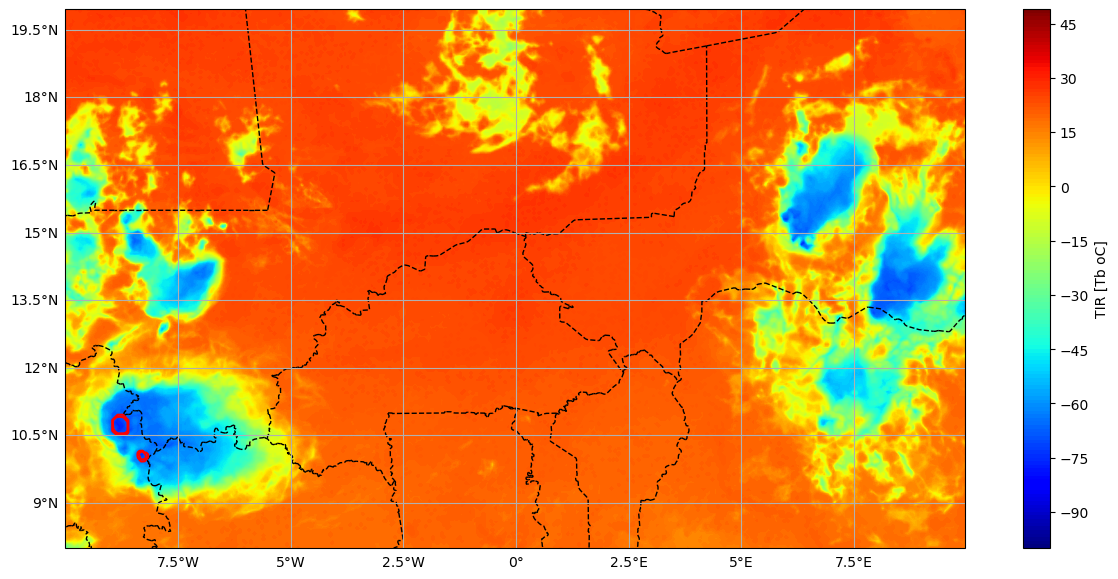

In [11]:
day = 24*11

f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, tir[:,:,day], reg_lon, reg_lat, levels=np.arange(-100,50), cbar_label='TIR [Tb oC]', cmap='jet')
ax.contour(reg_lon, reg_lat, cores[:,:,day], levels=[-5,1,50], colors='r')

# ax.set_ylim(-38,28)
# ax.set_xlim(-23,52)

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


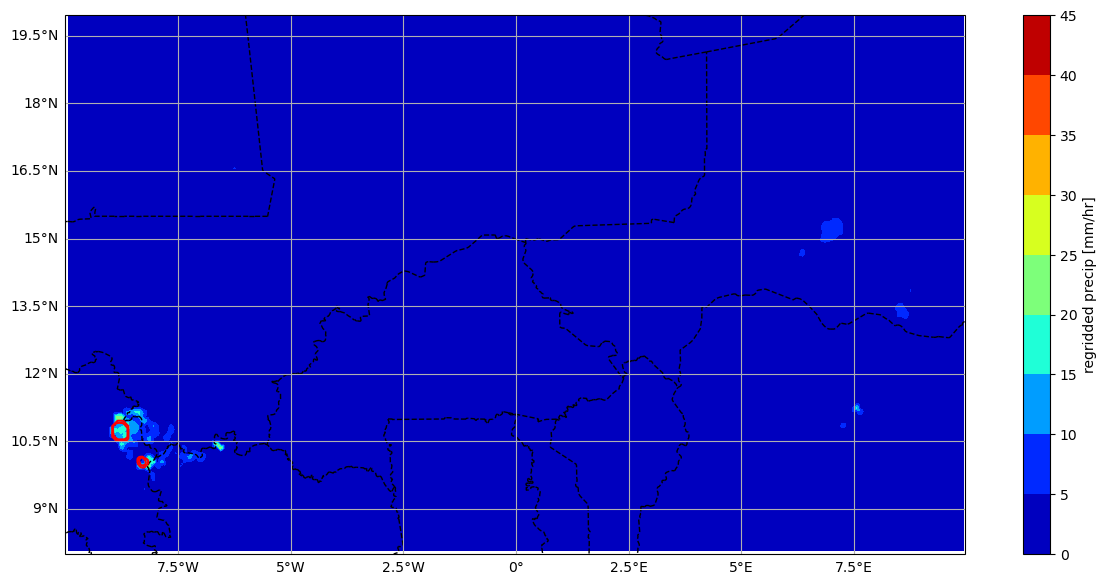

In [12]:
# plot IMERG rainfall and core data
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, regidded_precip[:,:,day], reg_lon, reg_lat, levels=np.arange(0,50,5),cbar_label='regridded precip [mm/hr]', cmap='jet')
ax.contour(reg_lon, reg_lat, cores[:,:,day], levels=[-5,1,50], colors='r')

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


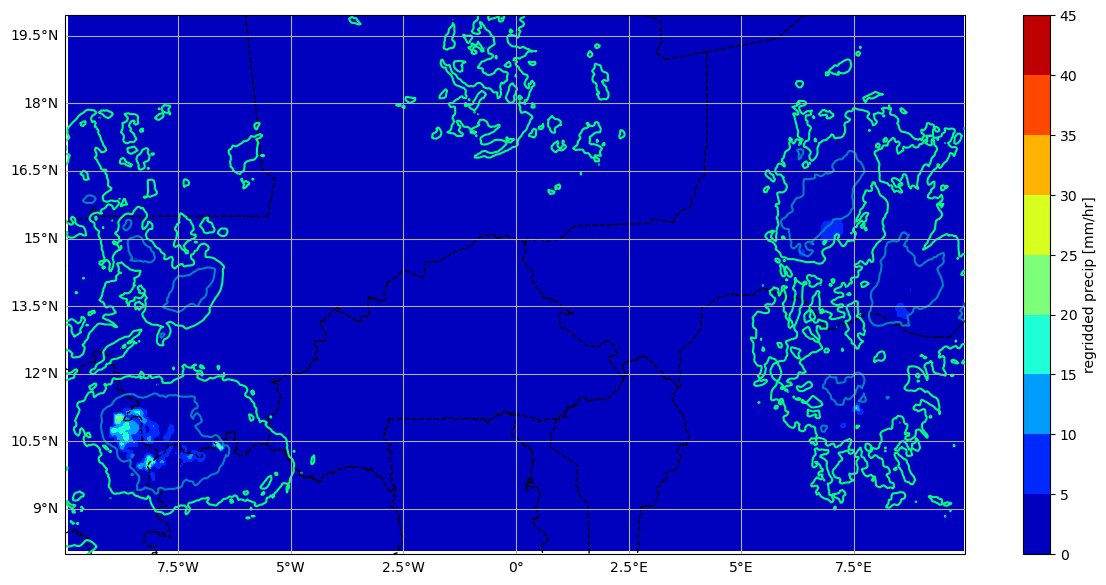

In [13]:
# plot IMERG rainfall and tir data
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, regidded_precip[:,:,day], reg_lon, reg_lat, levels=np.arange(0,50,5),cbar_label='regridded precip [mm/hr]', cmap='jet')
ax.contour(reg_lon, reg_lat, tir[:,:,day], levels=np.arange(-100,50,50), cmap='winter')


In [14]:
# find rainfall pixels collocated with cores
cores_1D = cores.flatten()
precip_1D = regidded_precip.flatten() # cores and precip have same size and indexing - obs in connis notebook
cores_ind_gt_0 = np.where(cores_1D>0)[0]
precip_collocated_w_cores = precip_1D[cores_ind_gt_0] #dat in connis notebook

cores_ind_gt_0
print(precip_collocated_w_cores.shape)
print(np.nanmax(precip_collocated_w_cores))

(1594357,)
68.91250612862169


In [15]:
print(np.nanmax(precip_1D))

72.09288815495735


In [16]:
# calculate frequency of rainfall above a threshold 
# dat = 
# threshold = 30mm/hr

def calc_treshReached(dat, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.isfinite(dat))

In [17]:
# calculate frequency of rainfall above a threshold relative to the same frequency for the full rainfall field (native)

def calc_treshReached_vsObs(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.isfinite(dat)) / np.sum(np.array(obs)>thresh)/np.sum(np.isfinite(obs))

In [18]:
# calculate fraction of caught rainfall pixels above a threshold
# calc_treshMissed in connis script

def calc_treshcaught(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.array(obs)>thresh)

In [19]:
# calculate frequency of rainfall above a threshold for regions with wavelet power above a given percentile

def percentile(dat, wav, thresh, perc):
    pval = np.percentile(wav, perc)
    dats = np.array(dat)[np.array(wav)>=pval]
    return np.sum(dats>thresh)/np.sum(np.isfinite(dats))

In [20]:
# fraction of pixels where threshold exceeded
# dat = precip_collocated_w_cores
# obs = precip_1D
thresh = 20
# treached = calc_treshReached(precip_collocated_w_cores,thresh)
# print(treached)

In [21]:

# fraction of caught pixels
# tcaught = calc_treshcaught(precip_collocated_w_cores,precip_1D, thresh)
# print(tcaught)

In [22]:
# fraction of threshold reached in dat vs threshold reached in obs
tfrac = calc_treshReached_vsObs(precip_collocated_w_cores,precip_1D, thresh)
print(tfrac)

8.21542461367833e-16


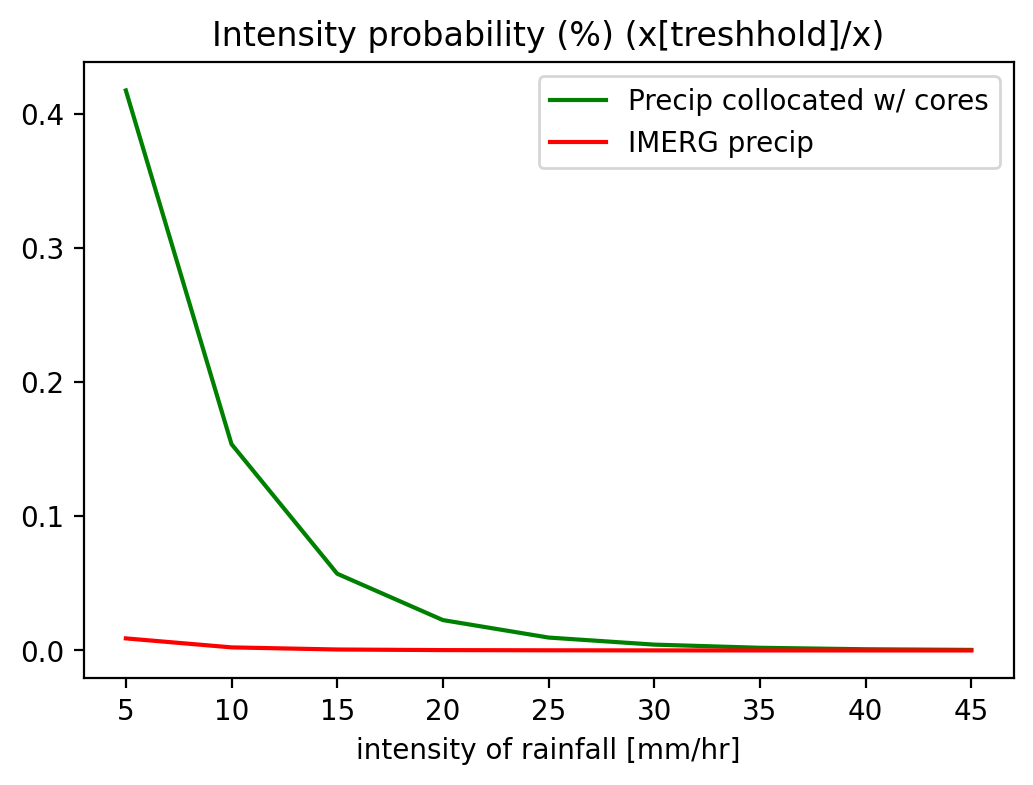

In [23]:
# fraction of rainfall pixels reached above intensity threshold to all rainfall pixels (collocated with cores)
f = plt.figure(figsize=(6,4), dpi=200)
ax = f.add_subplot(111)

treached = []
treached1 = []

for intens in range(5,50,5):   
    cc = calc_treshReached(precip_collocated_w_cores, intens)
    cc1 = calc_treshReached(precip_1D, intens)
    treached.append(cc)
    treached1.append(cc1)

ax.plot(range(5,50,5), treached,color='green',label='Precip collocated w/ cores')
ax.plot(range(5,50,5), treached1,color='red',label='IMERG precip')

ax.set_title("Intensity probability (%) (x[treshhold]/x)")
plt.xlabel('intensity of rainfall [mm/hr]')
plt.legend()

             

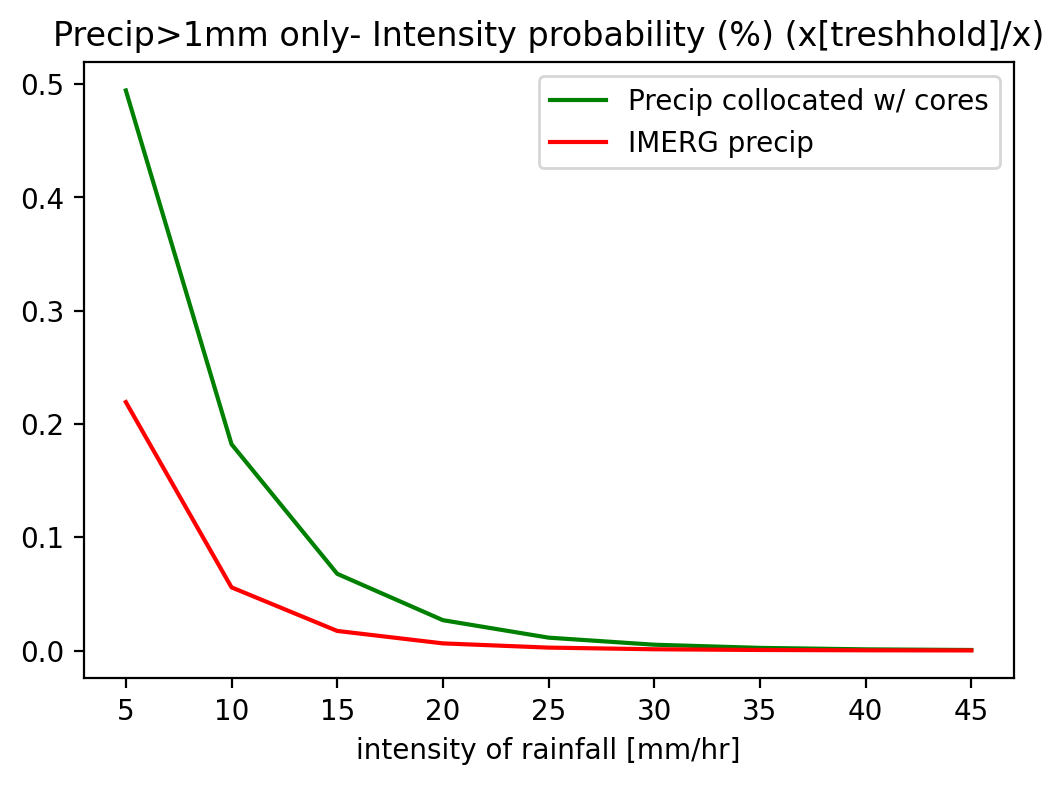

In [24]:
# fraction of rainfall pixels reached above intensity threshold to all rainfall pixels (collocated with cores)precip
precip_ind_gt_1 = np.where(precip_collocated_w_cores>1)[0] #find pixels with > 1mm precip
precip_collocated_w_cores_gt_1 = precip_collocated_w_cores[precip_ind_gt_1] #dat in connis notebook
precip_ind_gt_1 = np.where(precip_1D>1)[0] #find pixels with > 1mm precip
precip_1D_gt_1 = precip_1D[precip_ind_gt_1] 


f = plt.figure(figsize=(6,4), dpi=200)
ax = f.add_subplot(111)

treached = []
treached1 = []

for intens in range(5,50,5):   
    cc = calc_treshReached(precip_collocated_w_cores_gt_1, intens)
    cc1 = calc_treshReached(precip_1D_gt_1, intens)
    treached.append(cc)
    treached1.append(cc1)

ax.plot(range(5,50,5), treached,color='green',label='Precip collocated w/ cores')
ax.plot(range(5,50,5), treached1,color='red',label='IMERG precip')

ax.set_title("Precip>1mm only- Intensity probability (%) (x[treshhold]/x)")
plt.xlabel('intensity of rainfall [mm/hr]')
plt.legend()

# Open a file and use dump() 
with open('/users/global/jawahm/Documents/Africa_cores/stats/'+start_year+'_intensity_'+domain+'.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump([treached,treached1], file) 
    

Text(0.5, 0, 'intensity of rainfall [mm/hr]')

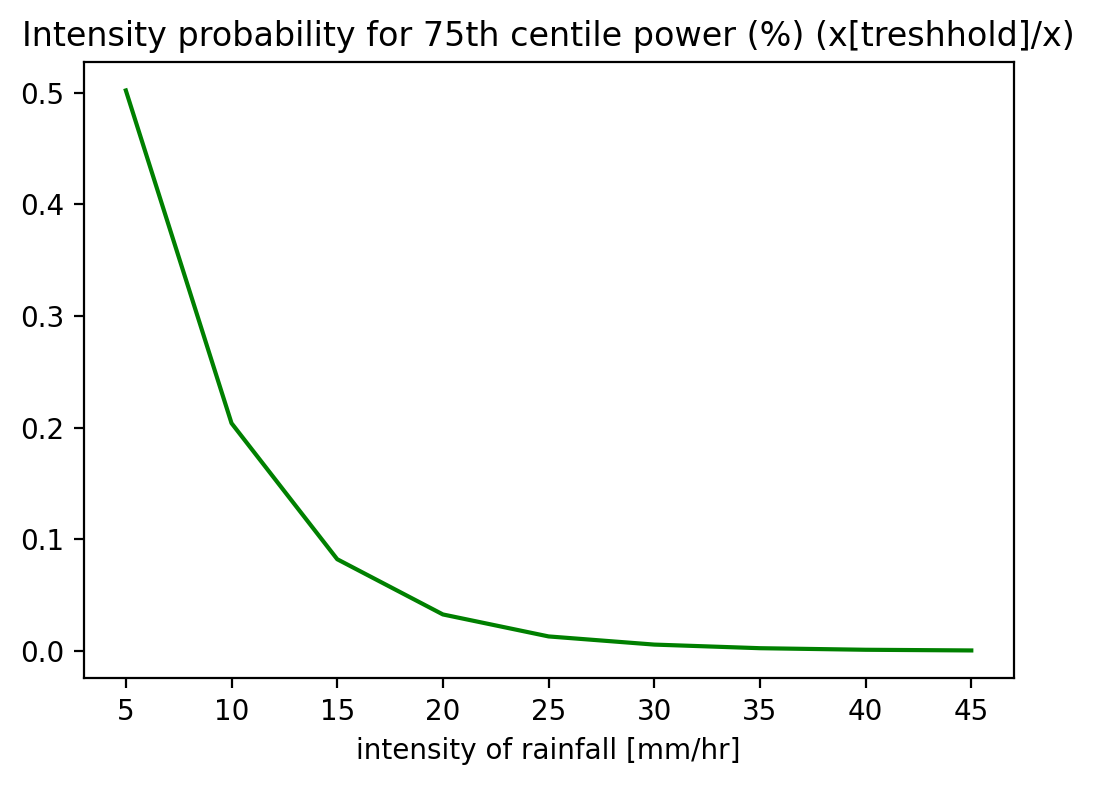

In [25]:
# plot frequency of caught pixels with rainfall above a threshold for regions with wavelet power above a given 
# percentile
f = plt.figure(figsize=(6,4), dpi=200)
ax = f.add_subplot(111)

treached = []
for intens in range(5,50,5):   
    cc = percentile(precip_collocated_w_cores, cores_1D[cores_ind_gt_0], intens, 75)
    treached.append(cc)
    #plotdic.append((treached,dat[1]))
#for pp in plotdic:    
#ax.plot(range(5,50,5), pp[0], label=pp[1])

ax.plot(range(5,50,5), treached,color='green')
ax.set_title("Intensity probability for 75th centile power (%) (x[treshhold]/x)")
plt.xlabel('intensity of rainfall [mm/hr]')
#ax.ylabel('fraction of rainfall pixels caught above intensity threshold that have >= 75th percentile wavelet power')
#plt.legend()
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'rainP_75p_wpower.jpg')

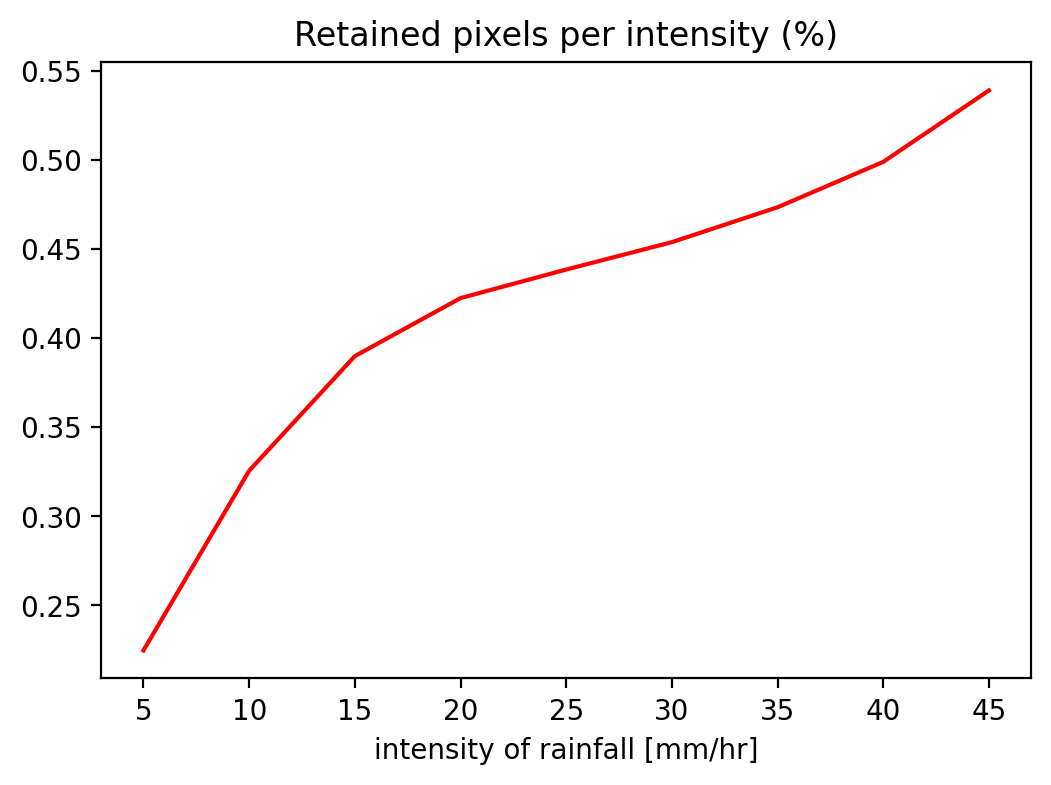

In [26]:
# fraction of rainfall pixels caught above intensity threshold to all caught rainfall pixels
f = plt.figure(figsize=(6,4), dpi=200)
ax = f.add_subplot(111)

tcaught = []
for intens in range(5,50,5):   
    cc = calc_treshcaught(precip_collocated_w_cores_gt_1, precip_1D_gt_1, intens)
#    cc = calc_treshcaught(precip_collocated_w_cores, precip_1D, intens)
    tcaught.append(cc)

ax.plot(range(5,50,5), tcaught,color='red')
ax.set_title("Retained pixels per intensity (%)")
plt.xlabel('intensity of rainfall [mm/hr]')
f.savefig('/users/global/jawahm/Documents/Africa_cores/figures/'+start_year+'_retained_pixels_'+domain+'.jpg')  

# Open a file and use dump() 
with open('/users/global/jawahm/Documents/Africa_cores/stats/'+start_year+'_retained_pixels_'+domain+'.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(tcaught, file) 
 